# Main

## Mount Google Drive, Link to folder & install requirements

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
%cd /content/gdrive/MyDrive/IFT6756

/content/gdrive/MyDrive/IFT6756


In [3]:
!pip install -qr requirements.txt

     |████████████████████████████████| 81kB 6.1MB/s 
     |████████████████████████████████| 194kB 14.3MB/s 


## Imports

In [8]:
# Miscellaneous
%matplotlib inline
from typing import Tuple
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from dataclasses import dataclass

# Privacy
from tensorflow_privacy.privacy.analysis import compute_dp_sgd_privacy

# My modules
from models import GAN, Autoencoder
from run_exp import train_autoencoder, train_gan
from utils import to_device, train_test, generate_samples, DWP, attribute_disclosure

# Pytorch
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

# Sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

# Check if CUDA is available
if not torch.cuda.is_available():
  warnings.warn('CUDA is not available.')

## Arguments

In [24]:
@dataclass
class Arguments_gan:
  # Data
  data_folder: str = '/content/gdrive/MyDrive/IFT6756/data'
  batch_size: int = 16

  # Model
  input_dim: int = 9
  embedding_dim: int = 64
  random_dim: int = 100
  is_finetuning: bool = False
  hidden_D: Tuple[int, ...] = (128, 64, 32)
  hidden_G: Tuple[int, ...] = (128, 256)

  # Differential privacy
  is_DP: bool = False
  sigma: float = 0.1
  delta: float = 10e-3

  # Optimization
  n_critic: int = 5
  clip_value: float = 0.01
  lr: float = 0.00005
  epochs: int = 50

  # Miscellaneous
  device: str = 'cpu'
  decoder = torch.load("/content/gdrive/MyDrive/IFT6756/saved_models/decoder.pt")
  verbose: bool = True


@dataclass
class Arguments_ae:
  # Data
  data_folder: str = '/content/gdrive/MyDrive/IFT6756/data'
  batch_size: int = 16

  # Model
  input_dim: int = 9
  latent_dim: int = 64
  hidden: Tuple[int, ...] = (9,16,32)

  # Optimization
  lr: float = 1e-3
  epochs: int = 50 

  # Miscellaneous
  device: str = 'cpu'


## Data

The features are

- NP: Number of household people
- HHT: Household or family type
- HINCP: Household income 
- HUPAC: Household presence and age of children 
- WIF: Workers in family during the last 12 months
- AGEP: Age of the person
- SEX: Gender of the person
- ESR: Employment status of the person 
- RAC1P: Recorded detailed race 


In [40]:
# Load data 
# Uncomment this block to create train, test sets from the data
"""
dfs = []
for i in range(1, 5):
  path = f'/content/gdrive/MyDrive/IFT6756/data/PUMA-120{i}-2012to2016-5%_Treated.csv'
  dfs.append(pd.read_csv(path))
df = pd.concat(dfs, axis=0, ignore_index=True)
train, test = train_test(df, ignore_pumas=False)
"""

# Load data and drop the state
train_df = pd.read_csv('/content/gdrive/MyDrive/IFT6756/data/TrainValTest/train_only.csv', index_col=0).drop(["ST"], axis=1)
test_df = pd.read_csv('/content/gdrive/MyDrive/IFT6756/data/TrainValTest/test_only.csv', index_col=0).drop(["ST"], axis=1)
# Make puma in range 0 to 4 (original pumas are 1201, 1202, 1203, 1204)
train_df['PUMA'] = train_df['PUMA'].apply(lambda x: x - 1201)
test_df['PUMA'] = test_df['PUMA'].apply(lambda x: x - 1201)
# To numpy arrays 
train = train_df.values
test = test_df.values
# To tensors
train_tensor = torch.tensor(train, dtype=torch.float32)
test_tensor = torch.tensor(test, dtype=torch.float32)

In [41]:
train_df.head()

,HINCP,NP,AGEP,RAC1P,ESR,SEX,WIF,HUPAC,HHT,PUMA
18617,5,4,69,1,6,2,3,1,3,3
15046,2,6,4,1,0,1,2,3,1,3
12955,5,4,7,1,0,1,4,2,1,2
6133,3,3,77,1,6,1,3,4,1,1
4221,6,3,25,1,1,1,4,4,1,0


## Pretraining the decoder

### Initialization

In [42]:
# Experiment's details
args = Arguments_ae(batch_size=16,
                    input_dim=10,
                    latent_dim=64,
                    hidden=(9,16,32),
                    lr=1e-3,
                    epochs=50,
                    device="cuda")

In [43]:
# DataLoader
train_loader = DataLoader(train_tensor,
                              batch_size=args.batch_size,
                              shuffle=False)
val_loader = DataLoader(test_tensor,
                            batch_size=args.batch_size,
                            shuffle=False)

In [44]:
# Model
autoencoder = Autoencoder(args)
print(autoencoder)

Autoencoder(
  (encoder): Encoder(
    (input_layer): Linear(in_features=10, out_features=9, bias=True)
    (layers): ModuleList(
      (0): Linear(in_features=9, out_features=16, bias=True)
      (1): Linear(in_features=16, out_features=32, bias=True)
    )
    (output_layer): Linear(in_features=32, out_features=64, bias=True)
    (relu): ReLU()
    (tanh): Tanh()
  )
  (decoder): Decoder(
    (input_layer): Linear(in_features=64, out_features=32, bias=True)
    (layers): ModuleList(
      (0): Linear(in_features=32, out_features=16, bias=True)
      (1): Linear(in_features=16, out_features=9, bias=True)
    )
    (output_layer): Linear(in_features=9, out_features=10, bias=True)
    (relu): ReLU()
  )
  (criterion): MSELoss()
)


### Training

In [45]:
# Training
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=args.lr)
train_autoencoder(autoencoder, train_loader, val_loader, optimizer, args)

### Visualization

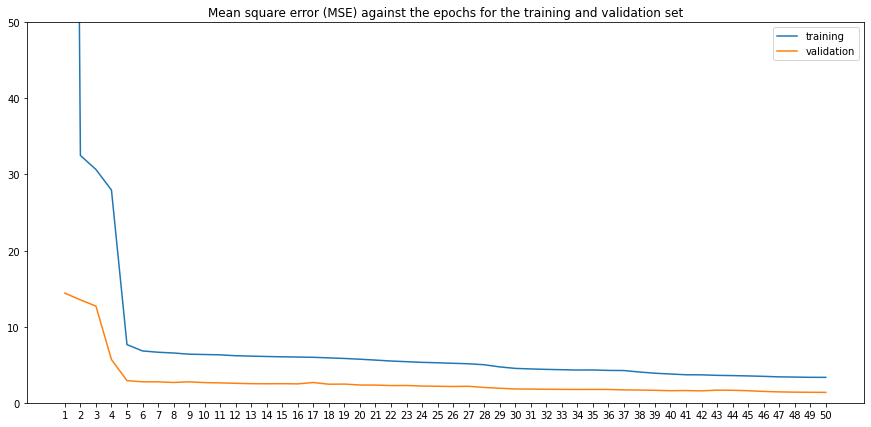

In [46]:
# Plot validation and training losses
epochs = range(1, args.epochs+1)
plt.figure(figsize=(15, 7))
plt.title("Mean square error (MSE) against the epochs for the training and validation set")
plt.plot(epochs, autoencoder.logs["train loss"], label="training")
plt.plot(epochs, autoencoder.logs["val loss"], label="validation")
plt.xticks(epochs)
plt.ylim((0, 50))
plt.legend(loc=1)
plt.show()

In [51]:
# Examples of reconstructions on validation set
n = 5
idx = random.sample(range(len(test)), n)
for i in idx:
  example = test_tensor[i].to(args.device)
  print("\nTarget")
  print(example)
  print("Reconstruction")
  print(autoencoder.decoder(autoencoder.encoder(example)))
#   print("Encoding")
#   print(autoencoder.encoder(example))



Target
tensor([3., 4., 9., 2., 0., 1., 2., 2., 3., 0.], device='cuda:0')
Reconstruction
tensor([2.5580, 3.9830, 9.0054, 1.4793, 0.0000, 1.4955, 2.2606, 2.1567, 1.7518,
        0.0000], device='cuda:0', grad_fn=<ReluBackward0>)

Target
tensor([ 5.,  2., 56.,  2.,  1.,  2.,  3.,  4.,  3.,  0.], device='cuda:0')
Reconstruction
tensor([ 4.7365,  1.8472, 55.7877,  1.1098,  1.0259,  1.4516,  2.7273,  3.7045,
         1.1595,  0.0000], device='cuda:0', grad_fn=<ReluBackward0>)

Target
tensor([ 5.,  6., 22.,  1.,  3.,  1.,  4.,  4.,  1.,  2.], device='cuda:0')
Reconstruction
tensor([ 5.5737,  5.0522, 22.0370,  0.0000,  3.5976,  1.4157,  3.5509,  2.1119,
         1.0702,  1.0160], device='cuda:0', grad_fn=<ReluBackward0>)

Target
tensor([4., 4., 0., 1., 0., 1., 3., 1., 1., 1.], device='cuda:0')
Reconstruction
tensor([4.0959, 4.3089, 0.0353, 1.1076, 0.0569, 1.4405, 2.7505, 2.0314, 1.4187,
        1.0847], device='cuda:0', grad_fn=<ReluBackward0>)

Target
tensor([ 4.,  4., 48.,  1.,  1.,  2.,  3

### Save decoder

In [52]:
torch.save(autoencoder.decoder, "/content/gdrive/MyDrive/IFT6756/saved_models/decoder2.pt")

## Training WGAN

### Initialization

In [ ]:
args = Arguments_gan(epochs=25,
                     hidden_D=(64,),
                     hidden_G=(128,),
                     is_DP=False,
                     is_finetuning=True,
                     device="cuda",
                     verbose=False)

In [ ]:
# DataLoader
train_loader = DataLoader(train_tensor,
                              batch_size=args.batch_size,
                              shuffle=False)
val_loader = DataLoader(val_tensor,
                            batch_size=args.batch_size,
                            shuffle=False)

In [ ]:
# Model
gan = GAN(args)
gan.to(args.device)
print(gan)

GAN(
  (G): Generator(
    (decoder): Decoder(
      (input_layer): Linear(in_features=64, out_features=32, bias=True)
      (layers): ModuleList(
        (0): Linear(in_features=32, out_features=16, bias=True)
        (1): Linear(in_features=16, out_features=9, bias=True)
      )
      (output_layer): Linear(in_features=9, out_features=9, bias=True)
      (relu): ReLU()
    )
    (input_layer): Linear(in_features=100, out_features=128, bias=True)
    (input_activation): ReLU()
    (layers): ModuleList()
    (output_layer): Linear(in_features=128, out_features=64, bias=True)
    (output_activation): Tanh()
  )
  (D): Discriminator(
    (input_layer): Linear(in_features=9, out_features=64, bias=True)
    (input_activation): ReLU()
    (layers): ModuleList()
    (output_layer): Linear(in_features=64, out_features=1, bias=True)
  )
)


### Training

In [ ]:
optimizer_D = torch.optim.RMSprop(gan.D.parameters(), args.lr)
optimizer_G = torch.optim.RMSprop(gan.G.parameters(), args.lr)
train_gan(gan, train_loader, optimizer_D, optimizer_G, args)

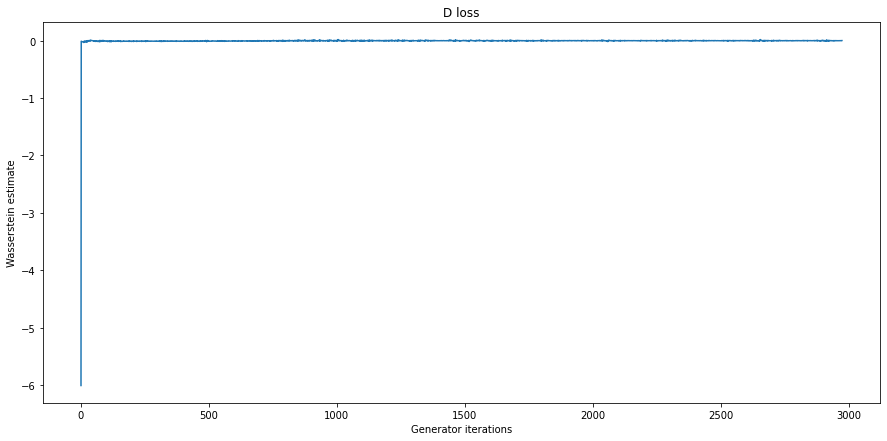

In [ ]:
plt.figure(figsize=(15, 7))
plt.title("D loss")
plt.xlabel("Generator iterations")
plt.ylabel("Wasserstein estimate")
plt.plot(gan.logs["approx. EM distance"])
plt.show()

Looks like we are converging really fast...

In [ ]:
gan.logs["approx. EM distance"][-10:]

[-0.00031658727675676346,
 0.00044156424701213837,
 -0.00029672496020793915,
 -0.00015860795974731445,
 -0.0004333183169364929,
 1.218356192111969e-05,
 0.0010557696223258972,
 -0.000714549794793129,
 -0.001827538013458252,
 0.0006639286875724792]

## Model Evaluation

### Computing $\epsilon$

Since the computation of $c_g$ is not trivial nor the implementation of the moment accountant method. We fall back on the **TensorFlow Privacy** library. 

we can use the `compute_dp_sgd_privacy` script to approximate the privacy loss $\epsilon$ for a given data set and training regime. `N` corresponds to the number of data points, and `noise_multiplier` corresponds to `sigma`. `batch_size` and `epochs` are the same as in training. `delta` is the tolerance probability for privacy loss beyond $\epsilon$.

 

In [ ]:
if args.is_DP:
    print(compute_dp_sgd_privacy.compute_dp_sgd_privacy(n=train.shape[0],
                                              batch_size=args.batch_size,
                                              noise_multiplier=args.sigma,
                                              epochs=args.epochs,
                                              delta=args.delta))


### Visual examples

In [ ]:
batch_synthetic = generate_samples(gan.G, 25, args)
print(batch_synthetic)

[[ 4.  2. 34.  0.  3.  1.  2.  3.  1.]
 [ 5.  3. 46.  1.  2.  2.  3.  3.  1.]
 [ 7.  9.  8.  4.  0.  3.  4.  4.  2.]
 [ 7.  7.  1.  7.  0.  3.  4.  3.  2.]
 [ 4.  5. 21.  5.  0.  2.  3.  3.  2.]
 [ 6.  6. 11.  2.  0.  2.  4.  4.  1.]
 [ 2.  2. 44.  0.  2.  1.  2.  3.  1.]
 [ 2.  0. 56.  0.  3.  1.  1.  4.  1.]
 [ 4.  4. 37.  0.  3.  2.  3.  4.  2.]
 [ 4.  2. 51.  1.  2.  1.  2.  2.  1.]
 [ 8.  7. 39.  1.  3.  2.  4.  3.  1.]
 [ 3.  0. 66.  0.  4.  1.  1.  4.  1.]
 [ 4.  4. 12.  3.  0.  2.  3.  4.  2.]
 [ 6.  6.  6.  5.  0.  2.  3.  3.  2.]
 [ 4.  5.  6.  2.  0.  2.  3.  2.  2.]
 [ 7.  8.  7.  0.  1.  2.  4.  4.  2.]
 [ 1.  0. 42.  1.  1.  1.  1.  2.  1.]
 [ 3.  2. 33.  0.  3.  1.  2.  2.  1.]
 [ 3.  2. 25.  2.  1.  1.  2.  3.  2.]
 [ 2.  2. 41.  0.  4.  1.  2.  3.  2.]
 [ 4.  2. 74.  1.  2.  1.  2.  3.  1.]
 [ 4.  2. 51.  0.  4.  1.  2.  3.  1.]
 [ 3.  1. 46.  0.  3.  1.  2.  4.  1.]
 [ 4.  3. 41.  2.  2.  1.  2.  3.  1.]
 [ 7.  6. 38.  1.  2.  2.  3.  3.  1.]]


### Compare the marginals

Generation of an equal number  of synthetic examples as in validation set

In [ ]:
batch_synthetic = generate_samples(gan.G, val_df.shape[0], args)
batch_synthetic_df = pd.DataFrame(batch_synthetic, columns=val_df.columns)

Some statistics for each dimension

In [ ]:
val_df.describe()

,HINCP,NP,AGEP,RAC1P,ESR,SEX,WIF,HUPAC,HHT
count,4053.000000,4053.000000,4053.000000,4053.000000,4053.000000,4053.000000,4053.000000,4053.000000,4053.000000
mean,4.381199,3.580804,38.176659,1.640020,2.024673,1.500864,2.771527,2.881322,1.332346
std,1.279735,1.444155,22.861754,1.826899,2.268694,0.500061,0.826874,1.103919,0.708036
min,2.000000,2.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000
25%,3.000000,2.000000,17.000000,1.000000,1.000000,1.000000,2.000000,2.000000,1.000000
50%,5.000000,3.000000,39.000000,1.000000,1.000000,2.000000,3.000000,3.000000,1.000000
75%,5.000000,4.000000,56.000000,1.000000,3.000000,2.000000,3.000000,4.000000,1.000000
max,6.000000,13.000000,94.000000,9.000000,6.000000,2.000000,4.000000,4.000000,3.000000


In [ ]:
batch_synthetic_df.describe()

,HINCP,NP,AGEP,RAC1P,ESR,SEX,WIF,HUPAC,HHT
count,4053.000000,4053.000000,4053.000000,4053.000000,4053.000000,4053.00000,4053.000000,4053.000000,4053.000000
mean,3.956082,3.577103,38.476437,1.452998,2.082408,1.52381,2.618554,3.162102,1.483839
std,1.538116,1.976354,19.951216,1.577729,1.439499,0.52314,0.929430,0.783045,0.551000
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,1.000000,0.000000
25%,3.000000,2.000000,24.000000,0.000000,1.000000,1.00000,2.000000,3.000000,1.000000
50%,4.000000,3.000000,37.000000,1.000000,2.000000,2.00000,3.000000,3.000000,2.000000
75%,5.000000,5.000000,52.000000,2.000000,3.000000,2.00000,3.000000,4.000000,2.000000
max,9.000000,10.000000,115.000000,9.000000,7.000000,3.00000,5.000000,6.000000,3.000000


Visual comparison of each dimension's distribution using histograms.

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


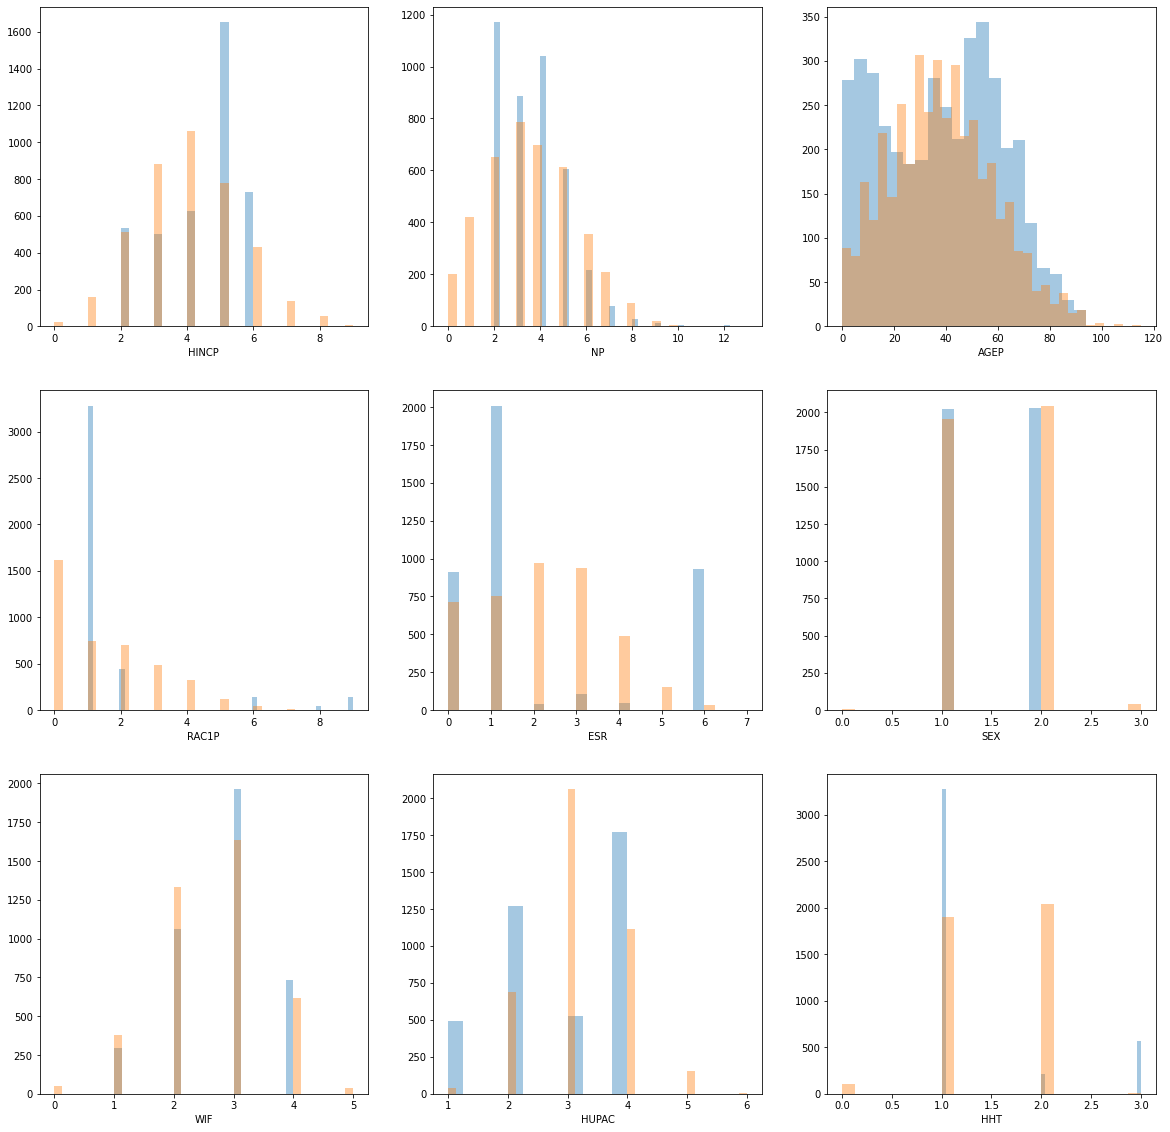

In [ ]:
fig, ax = plt.subplots(3, 3, figsize=(20, 20))
k = 0
col = val_df.columns
for i in range(3):
  for j in range(3):
    sns.distplot(val_df[col[k]], kde=False, ax=ax[i, j])
    sns.distplot(batch_synthetic_df[col[k]], kde=False, ax=ax[i, j])
    k += 1

### Dimension-wise prediction

After training the model with real training dataset to generate synthetic population, we choose one dimension to be the label. The remaining dimensions are used as features to train two classifier with same hyperparameters to predict the isolated dimension. Then, we use the two classifiers to predict de test set. We can assume that the close the performance of the classifiers, the better the quality of the synthetic samples.
(https://arxiv.org/pdf/1703.06490.pdf)

In [ ]:
# Generate synthetic train samples
train_synthetic = generate_samples(gan.G, train_df.shape[0], args)
train_synthetic = pd.DataFrame(train_synthetic, columns=train_df.columns)

In [ ]:
f1_scores = []
for col in train_df.columns:
    f1_scores.append(DWP(train_df, train_synthetic, val_df, col))

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


In [ ]:
for i, f1 in enumerate(f1_scores):
    f1_real, f1_synthetic = f1
    print(f"Dim:{train_df.columns[i]},\t F1 real: {f1_real:.3f},\t F1 synthetic: {f1_synthetic:.3f}")

Dim:HINCP,	 F1 real: 0.306,	 F1 synthetic: 0.277
Dim:NP,	 F1 real: 0.423,	 F1 synthetic: 0.254
Dim:AGEP,	 F1 real: 0.040,	 F1 synthetic: 0.017
Dim:RAC1P,	 F1 real: 0.726,	 F1 synthetic: 0.045
Dim:ESR,	 F1 real: 0.784,	 F1 synthetic: 0.086
Dim:SEX,	 F1 real: 0.537,	 F1 synthetic: 0.502
Dim:WIF,	 F1 real: 0.526,	 F1 synthetic: 0.424
Dim:HUPAC,	 F1 real: 0.630,	 F1 synthetic: 0.283
Dim:HHT,	 F1 real: 0.741,	 F1 synthetic: 0.580


## Considérations sur la confidentialité

### Attribute disclosure

On échantillonne $m$ exemples de l'ensemble d'entraînement. Pour chaque exemple $r$, on suppose que l'attaquant ne connait pas $s$ attributs déterminés aléatoirement. 

L'attaquant essaie de retrouver les attributs inconnnus de $r$ de la façon suivante. Il trouve les $k$ plus proche voisins de $r$ dans l'ensemble de données synthétiques. Les attributs inconnus de $r$ sont estimés par un vote majoritaire des attributs des $k$ plus proches voisins. Pour évaluer la classification, on compte simplement le nombre d'erreurs et de là on peut retrouver le ratio d'éléments retrouvés par rapport au nombre total d'éléments qu'on voulait retrouvé (accuracy). **(Quelque chose de moins naïf?)**

Ce processus est répété pour les $m$ exemples de l'ensemble d'entraînement. On peut déterminer le nombre moyen d'attributs retrouvés. Notons que $s$ attributs sont choisis aléatoirement pour chaque exemple. L'attaquant peut connaître différents attributs $s$ pour différents exemples.

**Décrire les défauts de cette méthode ?**

Décrire l'impact de la taille du dataset, du nombre d'attribut connu, ...
**Comparer avec le train_set directement**

#### Impact du nombre d'attributs connus

Pour un nombre fixe de données synthétiques. On trace la courbe de l'accuracy (pourcentage d'attributs effectivement retrouvés)

In [ ]:
print(f"Nombre total d'attributs: {train_df.columns.shape[0]}")

Nombre total d'attributs: 9


In [ ]:
# Generate synthetic train samples
synthetic = generate_samples(gan.G, train_df.shape[0], args)
synthetic_df = pd.DataFrame(train_synthetic, columns=train_df.columns)

In [ ]:
total_attributes = train_df.columns.shape[0]
m = 100
n_neighbhors = [1, 5, 10, 100]
n_attributes = [1, 2, 3, 4, 5, 6, 7, 8]  # to be guess
acc = {}
for k in n_neighbhors:
    acc[k] = []
    for s in n_attributes:
        n_guessed_attributes = s * m
        n_errors = attribute_disclosure(train_df, synthetic_df, m, s, k)
        acc[k].append(1 - n_errors/n_guessed_attributes)

In [ ]:
# acc

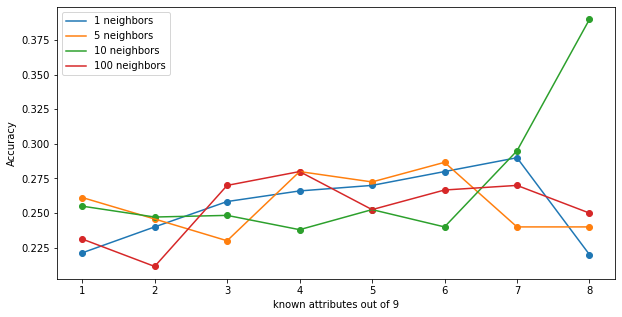

In [ ]:
known_attributes = [total_attributes - s for s in n_attributes]
plt.figure(figsize=(10,5))
for key, item in acc.items():
    plt.plot(known_attributes, item, label=f"{key} neighbors")
    plt.scatter(known_attributes, item)
plt.xticks = known_attributes
plt.xlabel(f"known attributes out of {total_attributes}")
plt.ylabel(f"Accuracy")
plt.legend(loc=0)
plt.show()

Same for original training set

In [ ]:
total_attributes = train_df.columns.shape[0]
m = 100
n_neighbhors = [1, 5, 10, 100]
n_attributes = [1, 2, 3, 4, 5, 6, 7, 8]  # to be guess
acc = {}
for k in n_neighbhors:
    acc[k] = []
    for s in n_attributes:
        n_guessed_attributes = s * m
        n_errors = attribute_disclosure(train_df, train_df, m, s, k)
        acc[k].append(1 - n_errors/n_guessed_attributes)

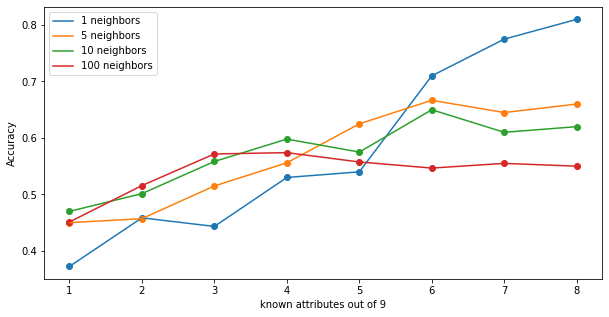

In [ ]:
known_attributes = [total_attributes - s for s in n_attributes]
plt.figure(figsize=(10,5))
for key, item in acc.items():
    plt.plot(known_attributes, item, label=f"{key} neighbors")
    plt.scatter(known_attributes, item)
plt.xticks = known_attributes
plt.xlabel(f"known attributes out of {total_attributes}")
plt.ylabel(f"Accuracy")
plt.legend(loc=0)
plt.show()

### Intersection 

Calculer l'intersection entre le training set et le 

In [ ]:
train_df.shape

(9454, 9)

In [ ]:
pd.merge(train_df.drop_duplicates(), train_synthetic.astype(int))

,HINCP,NP,AGEP,RAC1P,ESR,SEX,WIF,HUPAC,HHT
0,5,4,43,2,1,1,3,2,1
1,5,3,20,1,1,1,3,4,1
2,5,4,25,2,1,2,3,4,1
3,5,4,42,1,2,1,3,3,1
4,5,4,33,1,2,2,3,3,1
5,2,2,68,2,1,1,2,4,1
6,5,3,21,1,1,1,3,4,1
7,5,5,39,1,3,2,3,2,1
8,2,2,67,2,1,1,2,4,1
9,5,2,48,2,1,1,3,4,1


### Inception Score


In [ ]:
# from torch.utils.data import Dataset
# from torch.utils.data import DataLoader

In [ ]:
# @dataclass
# class Arguments_inception:
#   # Data
#   data_folder: str = '/content/gdrive/MyDrive/IFT6756/data'
#   batch_size: int = 16
#   class_weights = None

#   # Model
#   input_dim: int = 8
#   output_dim: int = 4
#   hidden_dim: int = 64

#   # Optimization
#   lr: float = 1e-3
#   epochs: int = 50

#   # Miscellaneous
#   device: str = 'cpu'


In [ ]:
# class Data(Dataset):
#     def __init__(self, X, y):
#         self.X = X
#         self.y = y
#     def __len__(self):
#         return len(self.X)
#     def __getitem__(self, idx):
#         return [self.X[idx], self.y[idx]]

In [ ]:
# # Inception model
# class Inception_model(nn.Module):
#     # One hidden layer neural network
#     def __init__(self, args):
#         super(Inception_model, self).__init__()

#         self.class_weights = args.class_weights
#         self.criterion = torch.nn.CrossEntropyLoss(weight=self.class_weights)

#         self.input_dim = args.input_dim
#         self.hidden_dim = args.hidden_dim
#         self.output_dim = args.output_dim
#         self.input_layer = nn.Linear(self.input_dim, self.hidden_dim)
#         self.input_activation = nn.ReLU()
#         self.output_layer = nn.Linear(self.hidden_dim, self.output_dim)
#         self.output_activation = nn.Softmax(dim=1)

#         self.logs = {"train loss": [], "val loss": []}

#     def forward(self, x):
#         x = self.input_layer(x)
#         x = self.input_activation(x)
#         x = self.output_layer(x)
#         x = self.output_activation(x)
#         return x


In [ ]:
# # Train inception model on training data
# def train_inception_model(model, train_loader, val_loader, optimizer, args):

#     train_size = len(train_loader.dataset)
#     val_size = len(val_loader.dataset)

#     for epoch in range(args.epochs):

#         running_loss = 0
#         running_val_loss = 0

#         for idx, (inputs, targets) in enumerate(train_loader):
#             # Prediction
#             input = to_device(inputs, args.device)
#             target = to_device(targets, args.device)
#             prediction = model(input)

#             # Loss
#             optimizer.zero_grad()
#             loss = model.criterion(prediction, target)
#             running_loss += loss.item()

#             # Backprop and params' update 
#             loss.backward()
#             optimizer.step()

#         for idx, (inputs, targets) in enumerate(val_loader):
#             # Prediction
#             input = to_device(inputs, args.device)
#             target = to_device(targets, args.device)
#             prediction = model(input)

#             # Loss
#             loss = model.criterion(prediction, target)
#             running_val_loss += loss.item()

#         # Average loss over the batches during the training
#         model.logs["train loss"].append(running_loss/train_size)
#         model.logs["val loss"].append(running_val_loss/train_size)

In [ ]:
# args_inception = Arguments_inception(input_dim=train_X[0].shape[0],
#                                      output_dim=train_y_oh[0].shape[0])

In [ ]:
# train_data = Data(train_X, train_y)
# val_data = Data(val_X, val_y)
# train_loader = DataLoader(train_data, batch_size=args_inception.batch_size)
# val_loader = DataLoader(val_data, batch_size=args_inception.batch_size)

In [ ]:
# inception_model = Inception_model(args_inception)
# print(inception_model)

Inception_model(
  (criterion): CrossEntropyLoss()
  (input_layer): Linear(in_features=8, out_features=64, bias=True)
  (input_activation): ReLU()
  (output_layer): Linear(in_features=64, out_features=3, bias=True)
  (output_activation): Softmax(dim=1)
)


In [ ]:
# optim = torch.optim.SGD(inception_model.parameters(), lr=args_inception.lr)

In [ ]:
# train_inception_model(inception_model, 
#                       train_loader, 
#                       val_loader, 
#                       optim, 
#                       args_inception)

In [ ]:
from sklearn.metrics import recall_score

In [ ]:
def inception_score(p_yx, eps=1E-16):
    # https://machinelearningmastery.com/how-to-implement-the-inception-score-from-scratch-for-evaluating-generated-images/
	# p(y)
	p_y = np.expand_dims(p_yx.mean(axis=0), 0)
	# kl divergence for each example
	kl_d = p_yx * (np.log(p_yx + eps) - np.log(p_y + eps))
	# sum over classes
	sum_kl_d = kl_d.sum(axis=1)
	# average over example
	avg_kl_d = np.mean(sum_kl_d)
	# undo the logs
	is_score = np.exp(avg_kl_d)
	return is_score

In [ ]:
train_X = torch.tensor(train[:, np.arange(train_X.shape[1]+1)!=2], dtype=torch.float32)
train_y = torch.tensor(train[:, 0], dtype=int)
train_y_oh = torch.nn.functional.one_hot(train_y)
val_X = torch.tensor(val[:, np.arange(train_X.shape[1]+1)!=2], dtype=torch.float32)
val_y = torch.tensor(val[:, 0], dtype=int)
val_y_oh = torch.nn.functional.one_hot(val_y)

In [ ]:
lr = LogisticRegression(max_iter=1000, class_weight="balanced")
lr.fit(train_X, train_y)
pred_prob = lr.predict_proba(val_X)

In [ ]:
pred_prob

array([[2.37362903e-18, 3.24282907e-08, 1.23942655e-02, 9.77333311e-01,
        1.02723908e-02],
       [5.92421163e-09, 1.16421571e-02, 9.68749789e-01, 1.96080277e-02,
        2.02397854e-08],
       [7.28005522e-18, 6.27947953e-08, 2.01320722e-02, 9.71126486e-01,
        8.74137865e-03],
       ...,
       [1.29566239e-18, 2.53801412e-08, 1.02503122e-02, 9.78946686e-01,
        1.08029761e-02],
       [7.44847179e-31, 5.48308594e-17, 7.24329692e-08, 1.63660874e-02,
        9.83633840e-01],
       [9.92662370e-01, 7.33761296e-03, 1.67699216e-08, 7.56545971e-18,
        3.31236203e-32]])

In [ ]:
inception_score(pred_prob)

4.012330841300396

tensor([5, 4, 5,  ..., 5, 6, 2])

In [ ]:
print(recall_score(val_y, lr.predict(val_X), average='weighted'))

1.0
